<div class="alert alert-block alert-danger">  
    <h1><center><strong> Sentiment Analysis: Sarcazm Detection -- Arabic Language</strong></center></h1>
    <i></i>
</div>
<img src="img/image.jpg" style="width:60%; border-radius:20%" >
<h2 style="color: #2F4F4F">Sarcasm is the use of words usually used to either mock or annoy someone, or for humorous purposes.</h2>


<h2 style="color: #2F4F4F">Here, we will detect the Sarcazem in tweets in Arabic language </h2> 


# Importing Necesseties

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import itertools
from plotly import graph_objs as go


import nltk
from farasa.stemmer import FarasaStemmer
import gensim
import arabic_reshaper
from bidi.algorithm import get_display
from nltk.corpus import stopwords

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import emojis
import re
# stemmer =  FarasaStemmer(interactive=True)

In [3]:
stemmer =  FarasaStemmer(interactive=True)

[2021-06-19 09:11:16,734 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


# Reading the data

In [4]:
df_train = pd.read_csv(r"data/train.csv")
df_train2 = pd.read_csv(r"data/testing_data_with_labels.csv")
df_test = pd.read_csv(r"data/test.csv")

In [5]:
df_train = pd.concat([df_train, df_train2])

# Exploratory Data Analysis(EDA)
<pre>How do we get from data to answers? 
Exploratory data analysis is a process for exploring datasets, answering questions, 
and visualizing results.</pre>

In [6]:
# Get the first 5 rows of the train data
df_train.head()

dialect  sarcasm sentiment original_sentiment  \
0    gulf    False  negative           negative   
1     msa    False   neutral           positive   
2   egypt    False   neutral            neutral   
3  levant     True   neutral           negative   
4     msa    False   neutral           negative   

                                               tweet   source Unnamed: 6  
0  "نصيحه ما عمرك اتنزل لعبة سوبر ماريو مش زي ما ...  semeval        NaN  
1  "#نادين_نسيب_نجيم ❤️❤️❤️مجلة #ماري_كلير 💭#ملكة...  semeval        NaN  
2                      "@Alito_NBA اتوقع انه بيستمر"  semeval        NaN  
3     "@KSA24 يعني "بموافقتنا" لأن دمشق صايرة موسكو"  semeval        NaN  
4  "RT @alaahmad20: قائد في الحرس يعترف بفقدان ال...  semeval        NaN

In [7]:
# Get the first 5 rows of the train data
df_test.head()

dialect  sarcasm sentiment original_sentiment  \
0     msa     True  negative           negative   
1    gulf    False  positive            neutral   
2     msa     True   neutral            neutral   
3     msa    False   neutral            neutral   
4     msa    False   neutral            neutral   

                                               tweet   source Unnamed: 6  \
0  "@AbuEmad74241481 @Cesars2014 هههههه حزب الله ...  semeval        NaN   
1  "RT @JannetForster: البنات اللي مa صامو بقولكم...  semeval        NaN   
2             اشارة رابعة اشبه بنار تحرق الانقلابيين     astd        NaN   
3  "@EGYPTAIR ما هي مميزات درجه بزنس علماً اني في...  semeval        NaN   
4  ما لا تراه على التلفاز منافسة شديدة بين المرشح...  semeval        NaN   

  Unnamed: 7 Unnamed: 8  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN

In [8]:
# The shape of the train data
print("The Number of rows in the train data: "+str(df_train.shape[0]))
print("The Number of columns in the train data: "+str(df_train.shape[1]))

The Number of rows in the train data: 11441
The Number of columns in the train data: 7


In [9]:
# The shape of the train data
print("The Number of rows in the train data: "+str(df_test.shape[0]))
print("The Number of columns in the train data: "+str(df_test.shape[1]))

The Number of rows in the train data: 2110
The Number of columns in the train data: 9


In [10]:
# Check if the train data contains null values
df_train.isna().sum()

dialect                   0
sarcasm                   0
sentiment                 0
original_sentiment     3000
tweet                     0
source                 3000
Unnamed: 6            11440
dtype: int64

In [11]:
# Check if the test data contains null values
df_train.isna().sum()

dialect                   0
sarcasm                   0
sentiment                 0
original_sentiment     3000
tweet                     0
source                 3000
Unnamed: 6            11440
dtype: int64

In [12]:
# Number of sarcasm Tweets
s1 =str(len(df_train[df_train["sarcasm"]==True]))
s2= str(len(df_train[df_train["sarcasm"]==False]))
print("Sarcasm_Tweets_numbers: " +s1)
print("not sarcasm_Tweets_numbers: "+s2)

Sarcasm_Tweets_numbers: 2160
not sarcasm_Tweets_numbers: 9281


In [13]:
# Number of sarcasm Tweets
s1 =str(len(df_test[df_test["sarcasm"]==True]))
s2= str(len(df_test[df_test["sarcasm"]==False]))
print("Sarcasm_Tweets_numbers_test: " +s1)
print("not sarcasm_Tweets_numbers_test: "+s2)

Sarcasm_Tweets_numbers_test: 345
not sarcasm_Tweets_numbers_test: 1765


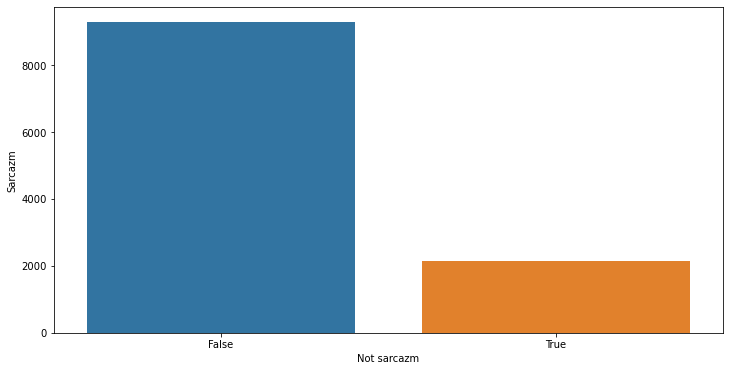

In [14]:
temp_train = df_train.groupby('sarcasm').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)
temp_train.style.background_gradient(cmap='Purples')

plt.figure(figsize=(12,6))
sns.countplot(x='sarcasm',data=df_train)
plt.xlabel('Not sarcazm') 
plt.ylabel('Sarcazm') 

fig = go.Figure(go.Funnelarea(
    text =["Not Sarcazm","Sarcazem"],
    values = temp_train.tweet,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"},

    ))
fig.show()

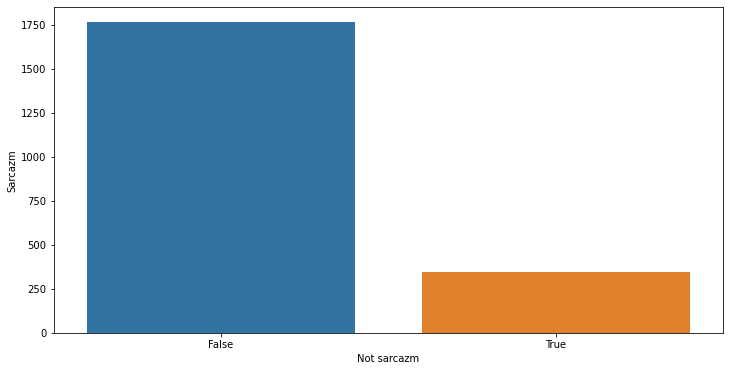

In [15]:
temp_test = df_test.groupby('sarcasm').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)
temp_test.style.background_gradient(cmap='Purples')

plt.figure(figsize=(12,6))
sns.countplot(x='sarcasm',data=df_test)
plt.xlabel('Not sarcazm') 
plt.ylabel('Sarcazm') 

fig = go.Figure(go.Funnelarea(
    text =["Nor Sarcazm","Sarcazem"],
    values = temp_test.tweet,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"},

    ))
fig.show()

## PreProcessing Data

In [16]:
# Take only the columns we are care about
train_data = df_train[['sarcasm', 'tweet']]
test_data = df_test[['sarcasm', 'tweet']]

In [17]:
# using farasa stemmer
train_data['cleaned_tweets']=train_data['tweet'].apply(lambda x: stemmer.stem(x))
test_data['cleaned_tweets']=test_data['tweet'].apply(lambda x: stemmer.stem(x))

In [18]:
# A function to convert any conflict char to just one char 
def normalize_arabic(text):
    tashkeel = re.compile(r'[\u064B-\u0652\u06D4\u0670\u0674\u06D5-\u06ED]+',re.UNICODE)
    text = tashkeel.sub("", text)
    
    text = re.sub(r'[^\u0621-\u064A0-9]', ' ', text, flags=re.UNICODE)
    text = re.sub(r'[\d]', ' ', text, flags=re.UNICODE)
    text = re.sub(' +', ' ', text)

    
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    
    return text   

In [22]:
train_data["cleaned_tweets"] = train_data["cleaned_tweets"].apply(normalize_arabic)
test_data["cleaned_tweets"] = test_data["cleaned_tweets"].apply(normalize_arabic)

In [26]:
# Removing Stop Words
stopwords_list = stopwords.words('arabic')
def remove_stopWords(sentence):
    terms=[]
    stopWords= set(stopwords_list)
    for term in sentence.split() : 
        if term not in stopWords :
            terms.append(term)
    return " ".join(terms)

In [29]:
# Removing Stop Words
train_data["cleaned_tweets"] = train_data["cleaned_tweets"].apply(remove_stopWords)
test_data["cleaned_tweets"] = test_data["cleaned_tweets"].apply(remove_stopWords)

In [31]:
train_data["cleaned_tweets"] 

0       نصيح عمر اتنزل لعبه سوبر ماريو مش زي كان متوقع...
1                نادين نسيب نجيم مجله ماري كلير ملك صحراء
2                                          اتوقع ان استمر
3                           عني موافقه ان دمشق صاير موسكو
4       قائد حرس اعترف فقدان سيطره امني شرقي و غربي اي...
                              ...                        
2995    تربكني ذكري مر طاريهوانسي بشر حول احق خيالهوات...
2996                               انا احسب مايتركون حركه
2997    فههههههههههد غشششششششاااااااام الببببببصصصصصما...
2998        كان امر اخفي انهيار دمعه سحق عين فضح اخفي قلب
2999    نسااء بابل كان يسحرن رجل عين فقط و نسااء يوم ي...
Name: cleaned_tweets, Length: 11441, dtype: object

# Build vocab list

In [34]:
vocab = []
for tw in train_data['cleaned_tweets']:
    for word in tw.split():
        if word not in vocab:
            vocab.append(word)

vocab = sorted(vocab)

In [35]:
print(len(vocab))

20639


# Prepare Data to Train

In [36]:
train_data['sarcasm'] = train_data['sarcasm'].apply(lambda x: 1 if x==True else 0)
test_data['sarcasm'] = test_data['sarcasm'].apply(lambda x: 1 if x==True else 0)

In [38]:
train_data.drop_duplicates(inplace=True)
test_data.drop_duplicates(inplace=True)
X_train = train_data['cleaned_tweets']
X_test = test_data['cleaned_tweets']
y_train = train_data['sarcasm'].tolist()
y_test = test_data['sarcasm'].tolist()

print('Size of train data: {}'.format(len(X_train)))
print('Size of test data: {}'.format(len(X_test)))
print('Size of train labels: {}'.format(len(y_train)))
print('Size of test labels: {}'.format(len(y_test)))

Size of train data: 11422
Size of test data: 2110
Size of train labels: 11422
Size of test labels: 2110


In [40]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

X_train_tokens = train_data['cleaned_tweets'].apply(tokenizer.tokenize)
X_test_tokens = test_data['cleaned_tweets'].apply(tokenizer.tokenize)

# Evaluation Matrix

In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

# Fitting First Classifier (Logistic Regression)

## Train the Model

# 1- Bag of Word

In [42]:
def bow_emb(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer


X_train_bow_emb, count_vectorizer = bow_emb(X_train)
X_test_bow_emb = count_vectorizer.transform(X_test)

## Visualize BOW

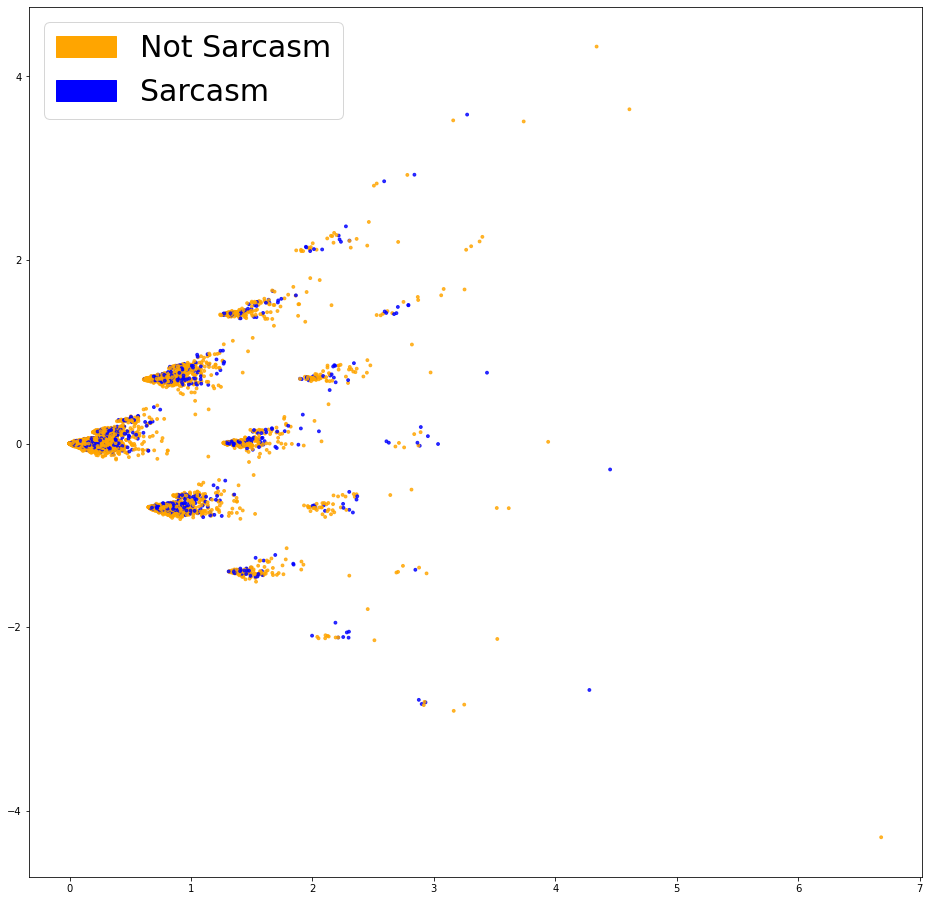

In [43]:
def plot_LSA(test_data, test_labels, plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange', 'blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Not Sarcasm')
            green_patch = mpatches.Patch(color='blue', label='Sarcasm')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_bow_emb, y_train)
plt.show()

In [44]:
lr_bow = LogisticRegression(solver='newton-cg', class_weight='balanced')
lr_bow.fit(X_train_bow_emb, y_train)

# Predicting on the test data
pred_test = lr_bow.predict(X_test_bow_emb)

#Calculating and printing the f1 score 
f1_test = f1_score(y_test, pred_test)
precision_test = precision_score(y_test, pred_test)
recall_test = recall_score(y_test, pred_test)
accuracy_test = accuracy_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)
print('The precision score for the testing data:', precision_test)
print('The recall score for the testing data:', recall_test)
print('The accuracy score for the testing data:', accuracy_test)


The f1 score for the testing data: 0.4366576819407008
The precision score for the testing data: 0.4080604534005038
The recall score for the testing data: 0.46956521739130436
The accuracy score for the testing data: 0.8018957345971564


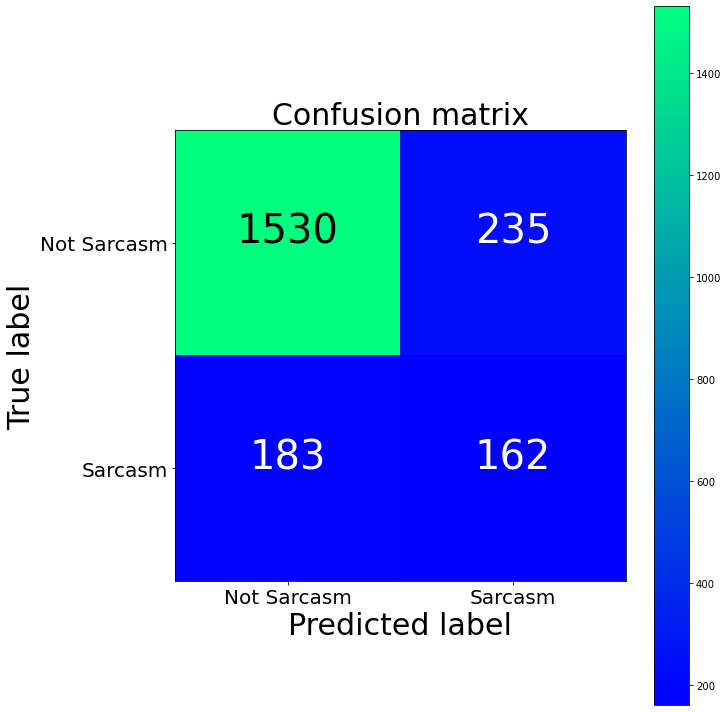

In [45]:
cm = confusion_matrix(y_test, pred_test)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Not Sarcasm','Sarcasm'], normalize=False, title='Confusion matrix')
plt.show()

## Handel the Imbalace Manually

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.4min finished


Text(0.5, 1.0, 'Scoring for different class weights')

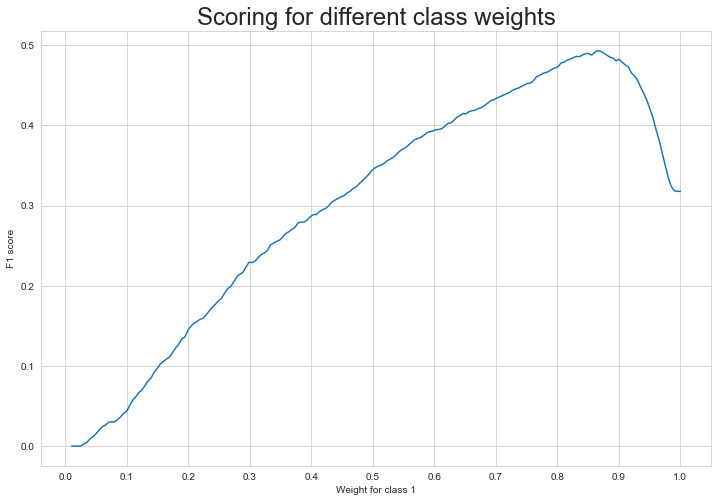

In [46]:
lr_bow = LogisticRegression(solver='newton-cg')

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr_bow, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train_bow_emb, y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

In [47]:
weight_for_high_score = weigh_data[weigh_data['score'] == np.max(weigh_data.score)]['weight']
weight_for_high_score

27    0.865678
Name: weight, dtype: float64

The f1 score for the testing data: 0.47007616974972805
The precision score for the testing data: 0.37630662020905925
The recall score for the testing data: 0.6260869565217392
The accuracy score for the testing data: 0.7691943127962085


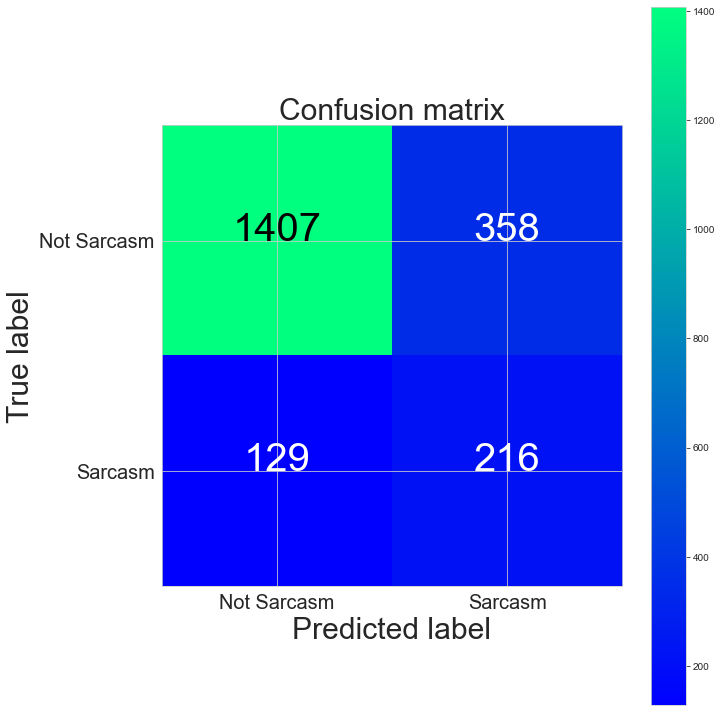

In [48]:
lr_bow = LogisticRegression(solver='newton-cg', class_weight={0: 1-weight_for_high_score, 1: weight_for_high_score})
lr_bow.fit(X_train_bow_emb, y_train)

# Predicting on the test data
pred_test = lr_bow.predict(X_test_bow_emb)

#Calculating and printing the f1 score 
f1_test = f1_score(y_test, pred_test)
precision_test = precision_score(y_test, pred_test)
recall_test = recall_score(y_test, pred_test)
accuracy_test = accuracy_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)
print('The precision score for the testing data:', precision_test)
print('The recall score for the testing data:', recall_test)
print('The accuracy score for the testing data:', accuracy_test)

#Ploting the confusion matrix
cm = confusion_matrix(y_test, pred_test)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Not Sarcasm','Sarcasm'], normalize=False, title='Confusion matrix')
plt.show()

In [49]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes = {}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, lr_bow, 10)

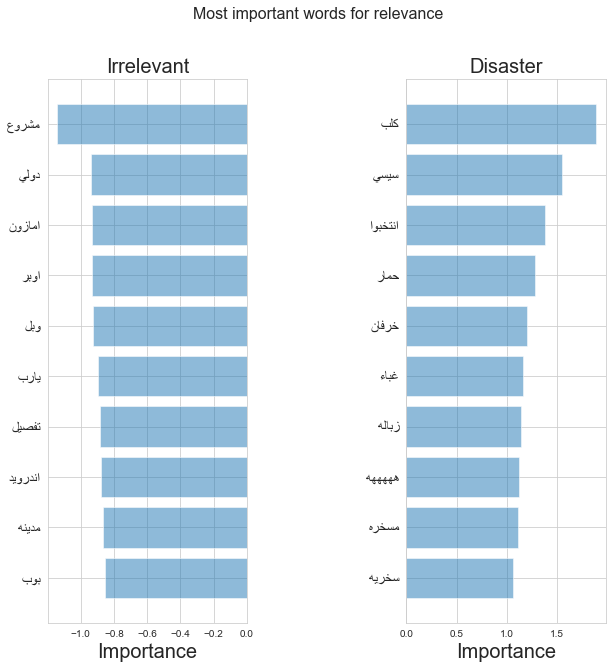

In [50]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    top_words = [get_display(arabic_reshaper.reshape(a[0])) for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    bottom_words = [get_display(arabic_reshaper.reshape(a[0])) for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    fig = plt.figure(figsize=(10, 10))  
    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

# 2- TF-IDF

In [51]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()
    train = tfidf_vectorizer.fit_transform(data)  
    return train, tfidf_vectorizer

X_train_tfidf_emb, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf_emb = tfidf_vectorizer.transform(X_test)

## Visualize TF-IDF

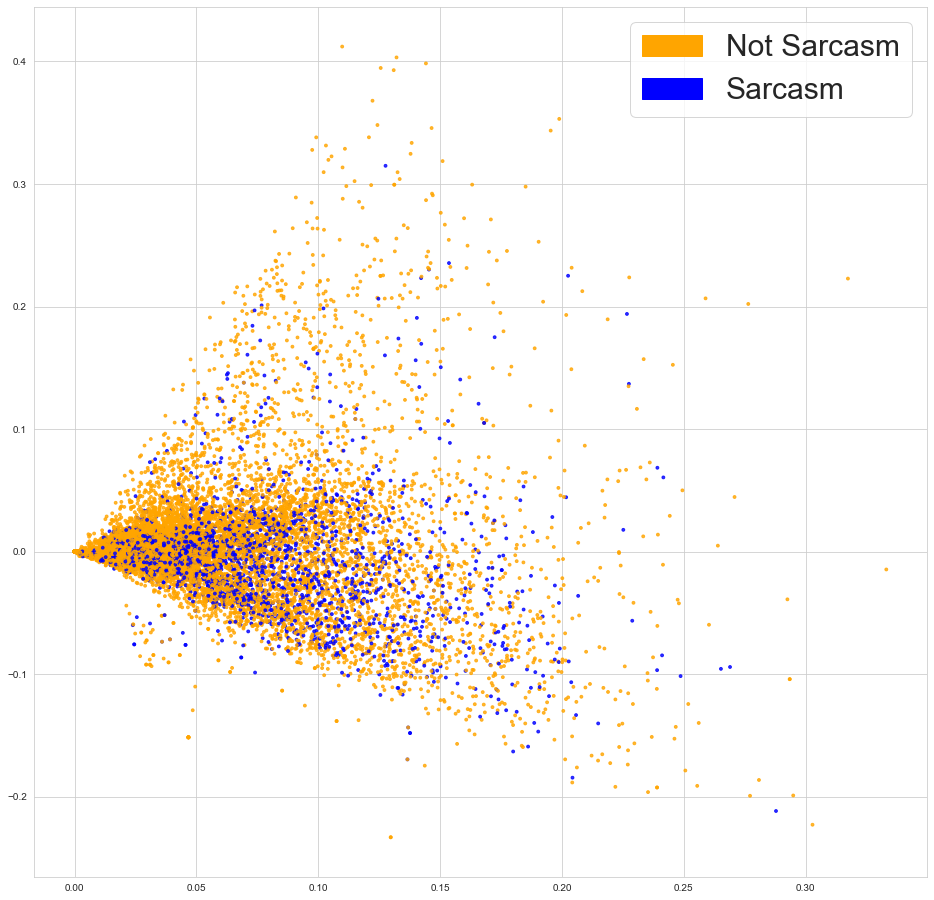

In [52]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf_emb, y_train)
plt.show()

In [53]:
lr_tfidf = LogisticRegression(solver='newton-cg', class_weight='balanced')
lr_tfidf.fit(X_train_tfidf_emb, y_train)

# Predicting on the test data
pred_test = lr_tfidf.predict(X_test_tfidf_emb)

#Calculating and printing the f1 score 
f1_test = f1_score(y_test, pred_test)
precision_test = precision_score(y_test, pred_test)
recall_test = recall_score(y_test, pred_test)
accuracy_test = accuracy_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)
print('The precision score for the testing data:', precision_test)
print('The recall score for the testing data:', recall_test)
print('The accuracy score for the testing data:', accuracy_test)

The f1 score for the testing data: 0.47586206896551725
The precision score for the testing data: 0.3942857142857143
The recall score for the testing data: 0.6
The accuracy score for the testing data: 0.7838862559241706


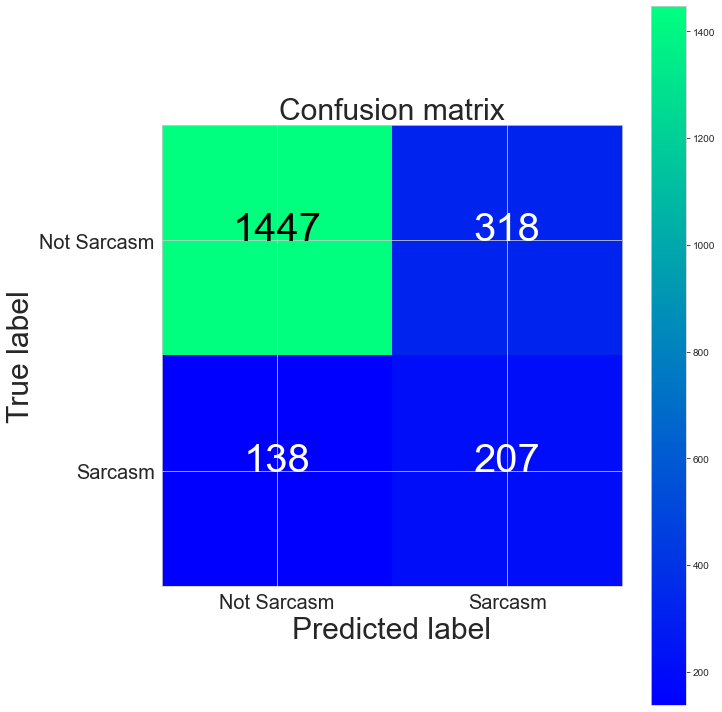

In [54]:
cm = confusion_matrix(y_test, pred_test)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Not Sarcasm','Sarcasm'], normalize=False, title='Confusion matrix')
plt.show()

## Handel the Imbalace Manually

The f1 score for the testing data: 0.42877291960507763
The precision score for the testing data: 0.2833178005591799
The recall score for the testing data: 0.881159420289855
The accuracy score for the testing data: 0.6161137440758294


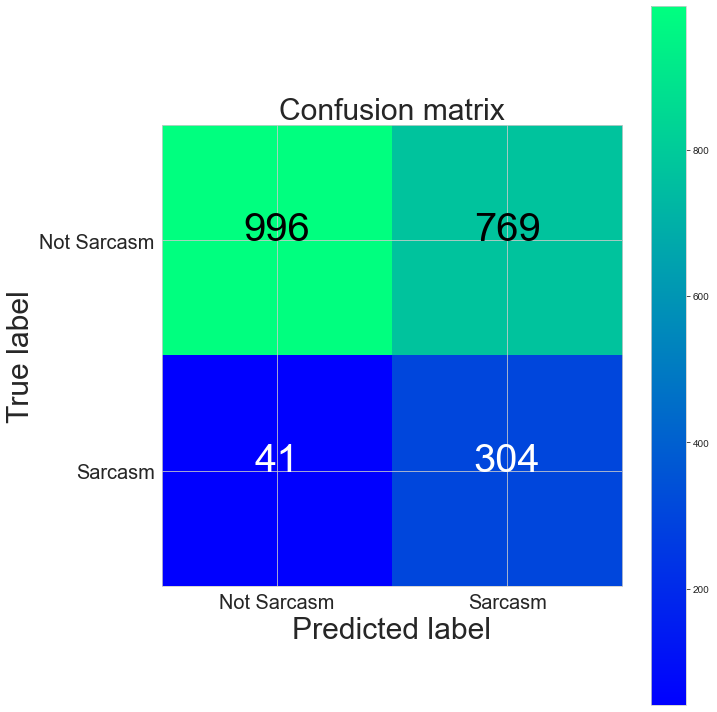

In [55]:
lr_tfidf = LogisticRegression(solver='newton-cg', class_weight={0: 1-weight_for_high_score, 1: weight_for_high_score})
lr_tfidf.fit(X_train_tfidf_emb, y_train)

# Predicting on the test data
pred_test = lr_tfidf.predict(X_test_tfidf_emb)

#Calculating and printing the f1 score 
f1_test = f1_score(y_test, pred_test)
precision_test = precision_score(y_test, pred_test)
recall_test = recall_score(y_test, pred_test)
accuracy_test = accuracy_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)
print('The precision score for the testing data:', precision_test)
print('The recall score for the testing data:', recall_test)
print('The accuracy score for the testing data:', accuracy_test)

#Ploting the confusion matrix
cm = confusion_matrix(y_test, pred_test)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Not Sarcasm','Sarcasm'], normalize=False, title='Confusion matrix')
plt.show()

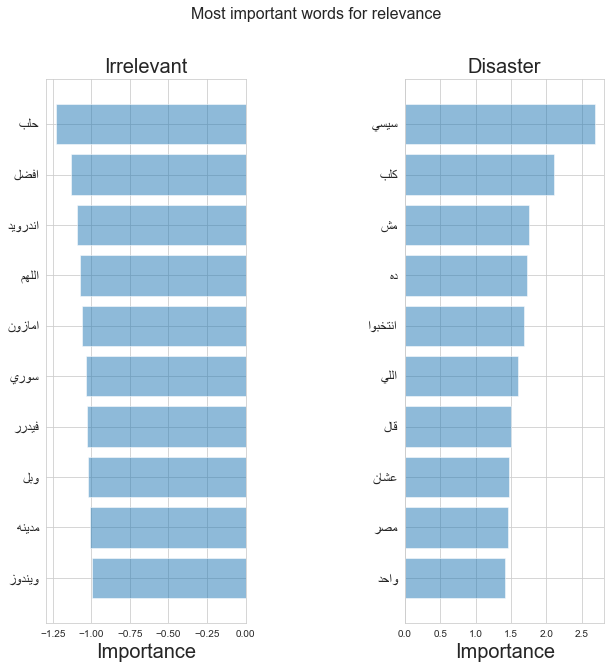

In [56]:
importance = get_most_important_features(tfidf_vectorizer, lr_tfidf, 10)

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

# 3- Pre-trained Word2Vec Model

In [57]:
LEN_OF_TRAIN_TWEETS = [len(i) for i in X_train]
NUM_TRAIN_WORDS = sum(LEN_OF_TRAIN_TWEETS)
TRAIN_MAX_LEN = max(LEN_OF_TRAIN_TWEETS)

LEN_OF_TEST_TWEETS = [len(i) for i in X_test]
NUM_TEST_WORDS = sum(LEN_OF_TEST_TWEETS)
TEST_MAX_LEN = max(LEN_OF_TEST_TWEETS)

In [58]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

train_tokenizer = Tokenizer(nb_words = NUM_TRAIN_WORDS)
train_tokenizer.fit_on_texts(X_train)
train_seq = train_tokenizer.texts_to_sequences(X_train)

test_tokenizer = Tokenizer(nb_words = NUM_TEST_WORDS)
test_tokenizer.fit_on_texts(X_test)
test_seq = test_tokenizer.texts_to_sequences(X_test)

In [59]:
X_train_padding = pad_sequences(train_seq, maxlen=TRAIN_MAX_LEN, padding='post')
X_test_padding = pad_sequences(test_seq, maxlen=TEST_MAX_LEN, padding='post')

In [60]:
print(X_train_padding.shape)
print(X_test_padding.shape)

(11422, 234)
(2110, 123)


In [61]:
import gensim

word2vec_path = "cbow_100.bin"
model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True, unicode_errors='ignore')   

In [62]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, data, generate_missing=False):
    embeddings = data.apply(lambda x: get_average_word2vec(x, vectors, generate_missing=generate_missing))
    return list(embeddings)

In [63]:
train_embeddings = get_word2vec_embeddings(model, X_train_tokens)
test_embeddings = get_word2vec_embeddings(model, X_test_tokens)

## Visualize W2V

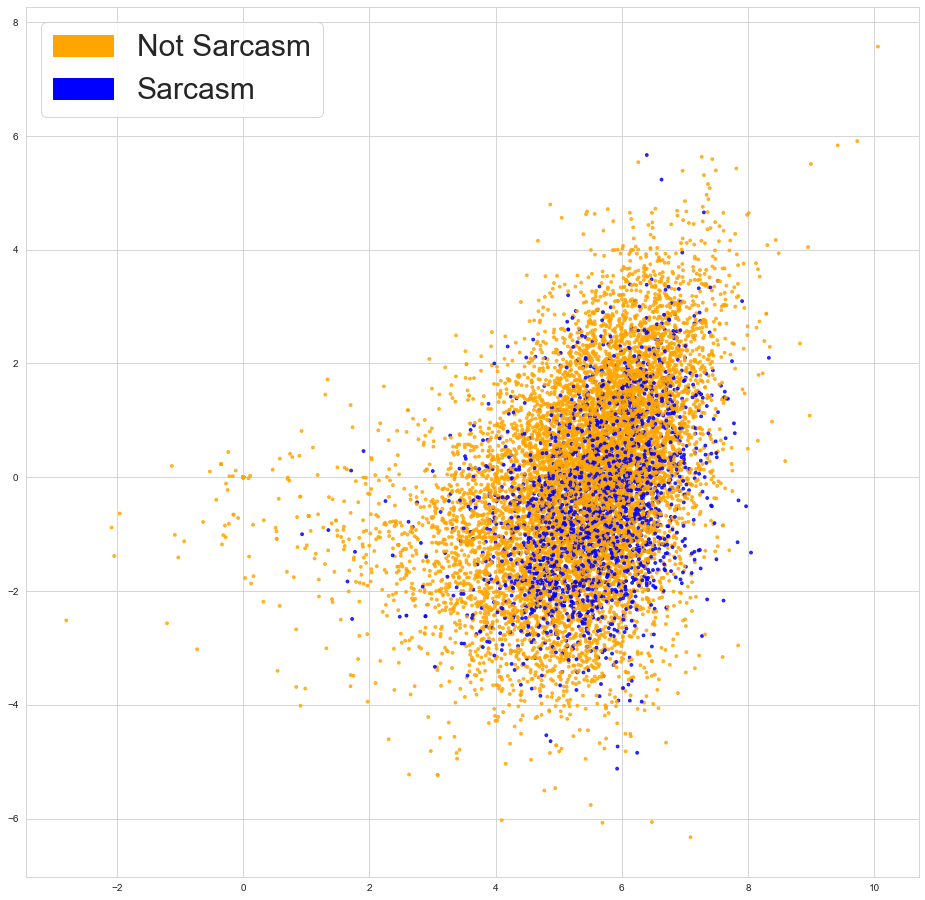

In [64]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(train_embeddings, y_train)
plt.show()

The f1 score for the testing data: 0.4838393731635652
The precision score for the testing data: 0.36538461538461536
The recall score for the testing data: 0.7159420289855073
The accuracy score for the testing data: 0.7502369668246446


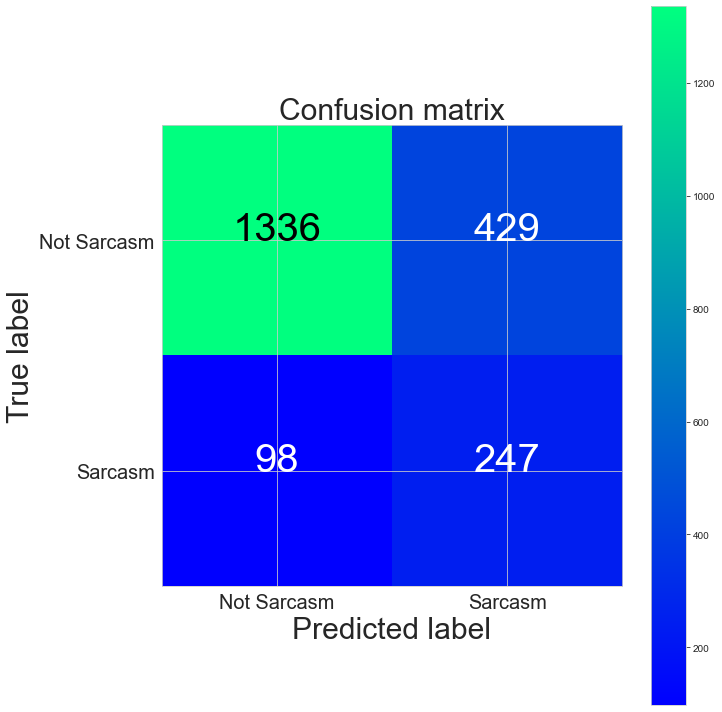

In [65]:
lr_w2v = LogisticRegression(solver='newton-cg', class_weight='balanced')
lr_w2v.fit(train_embeddings, y_train)

# Predicting on the test data
pred_test = lr_w2v.predict(test_embeddings)

#Calculating and printing the f1 score 
f1_test = f1_score(y_test, pred_test)
precision_test = precision_score(y_test, pred_test)
recall_test = recall_score(y_test, pred_test)
accuracy_test = accuracy_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)
print('The precision score for the testing data:', precision_test)
print('The recall score for the testing data:', recall_test)
print('The accuracy score for the testing data:', accuracy_test)

#Ploting the confusion matrix
cm = confusion_matrix(y_test, pred_test)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Not Sarcasm','Sarcasm'], normalize=False, title='Confusion matrix')
plt.show()

The f1 score for the testing data: 0.4695222405271829
The precision score for the testing data: 0.32796317606444186
The recall score for the testing data: 0.8260869565217391
The accuracy score for the testing data: 0.6947867298578199


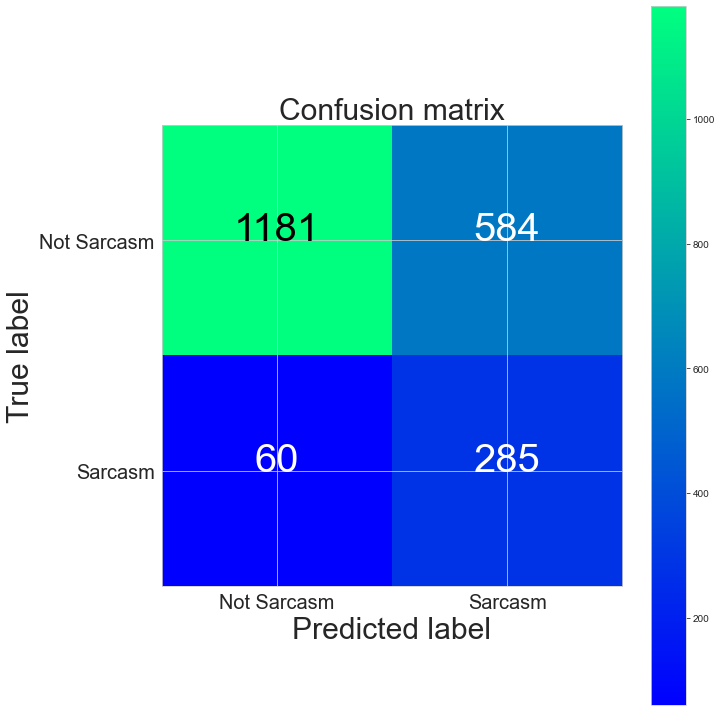

In [66]:
lr_w2v = LogisticRegression(solver='newton-cg', class_weight={0: 1-weight_for_high_score, 1: weight_for_high_score})
lr_w2v.fit(train_embeddings, y_train)

# Predicting on the test data
pred_test = lr_w2v.predict(test_embeddings)

#Calculating and printing the f1 score 
f1_test = f1_score(y_test, pred_test)
precision_test = precision_score(y_test, pred_test)
recall_test = recall_score(y_test, pred_test)
accuracy_test = accuracy_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)
print('The precision score for the testing data:', precision_test)
print('The recall score for the testing data:', recall_test)
print('The accuracy score for the testing data:', accuracy_test)

#Ploting the confusion matrix
cm = confusion_matrix(y_test, pred_test)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Not Sarcasm','Sarcasm'], normalize=False, title='Confusion matrix')
plt.show()

# Fitting Second Classifier (Support Vector Machine)

In [67]:
from sklearn.svm import SVC
svm = SVC(class_weight='balanced')
svm.fit(X_train_tfidf_emb, y_train)

# Predicting on the test data
pred_test = svm.predict(X_test_tfidf_emb)

#Calculating and printing the f1 score 
f1_test = f1_score(y_test, pred_test)
precision_test = precision_score(y_test, pred_test)
recall_test = recall_score(y_test, pred_test)
accuracy_test = accuracy_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)
print('The precision score for the testing data:', precision_test)
print('The recall score for the testing data:', recall_test)
print('The accuracy score for the testing data:', accuracy_test)


The f1 score for the testing data: 0.4006908462867012
The precision score for the testing data: 0.49572649572649574
The recall score for the testing data: 0.336231884057971
The accuracy score for the testing data: 0.8355450236966825


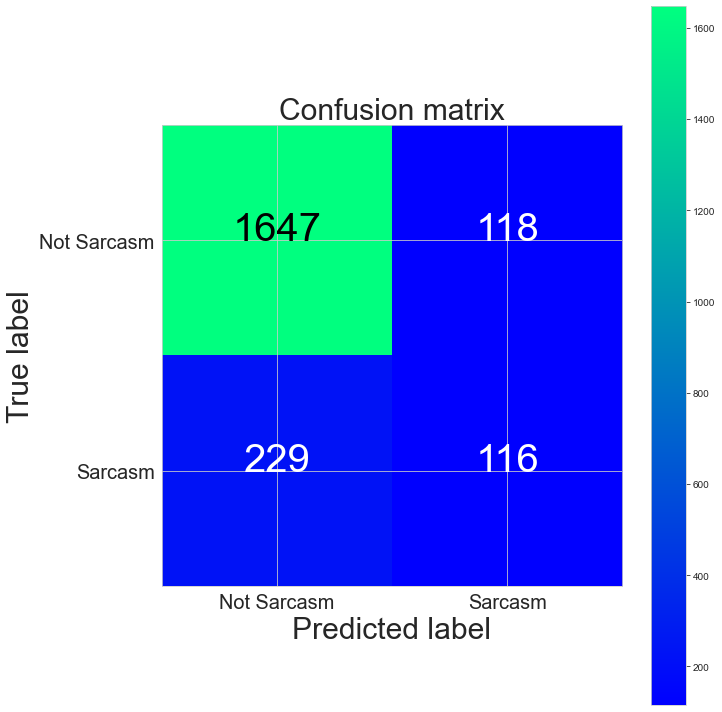

[[1647  118]
 [ 229  116]]


In [68]:
cm = confusion_matrix(y_test, pred_test)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Not Sarcasm','Sarcasm'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 72.8min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 121.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 172.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 255.1min finished


Text(0.5, 1.0, 'Scoring for different class weights')

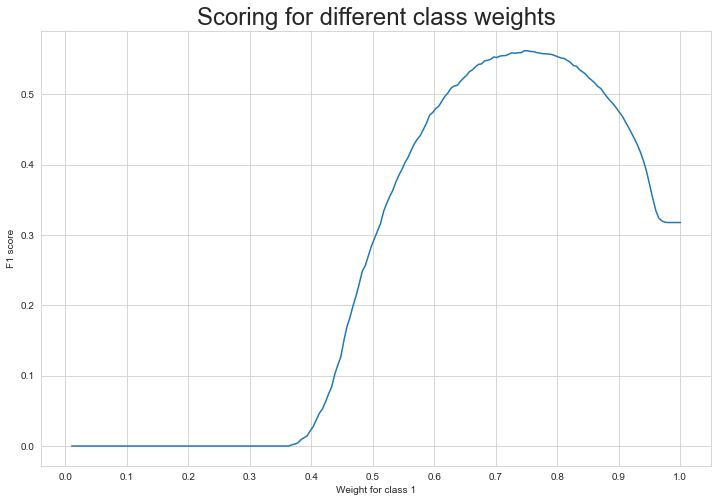

In [75]:
svm = SVC()

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= svm, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(train_embeddings,  y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

In [76]:
weight_for_high_score = weigh_data[weigh_data['score'] == np.max(weigh_data.score)]['weight']
weight_for_high_score

51    0.746281
Name: weight, dtype: float64

The f1 score for the testing data: 0.5368171021377672
The precision score for the testing data: 0.45472837022132795
The recall score for the testing data: 0.6550724637681159
The accuracy score for the testing data: 0.8151658767772512


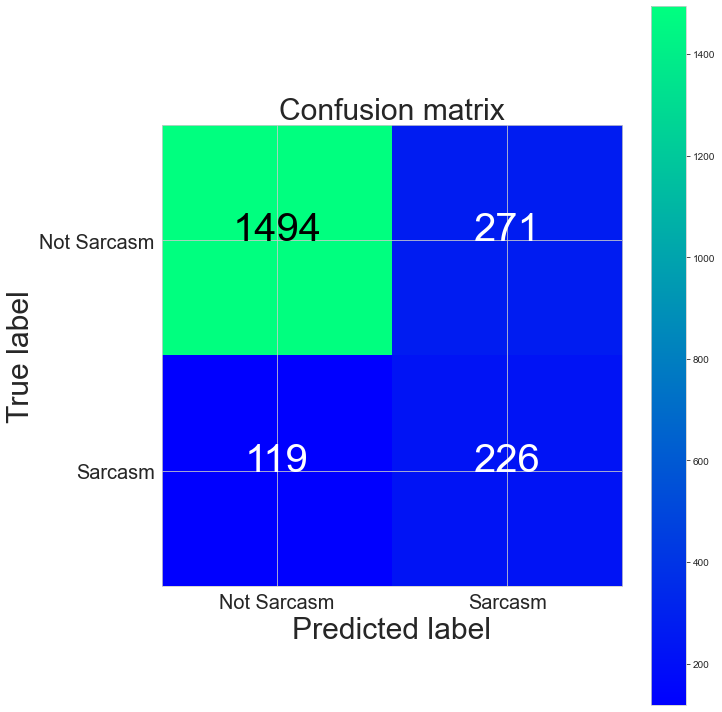

[[1494  271]
 [ 119  226]]


In [77]:
svm = SVC( class_weight={0: 1-weight_for_high_score, 1: weight_for_high_score})
svm.fit(train_embeddings, y_train)

# Predicting on the test data
pred_test = svm.predict(test_embeddings)

#Calculating and printing the f1 score 
f1_test = f1_score(y_test, pred_test)
precision_test = precision_score(y_test, pred_test)
recall_test = recall_score(y_test, pred_test)
accuracy_test = accuracy_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)
print('The precision score for the testing data:', precision_test)
print('The recall score for the testing data:', recall_test)
print('The accuracy score for the testing data:', accuracy_test)

#Ploting the confusion matrix
cm = confusion_matrix(y_test, pred_test)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Not Sarcasm','Sarcasm'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

# Other

In [ ]:
def extract_emojis(tweet):
    return list(emojis.get(tweet))

In [ ]:
def contain_emoji(tweet):
    emo_list = list(emojis.get(tweet))
    if emo_list == list():
        return False
    else:
        return True

In [ ]:
df['emoji'] = df['tweet'].apply(extract_emojis)
df.head()

dialect  ...       emoji
0    gulf  ...          []
1     msa  ...  [❤️, 💭, 👑]
2   egypt  ...          []
3  levant  ...          []
4     msa  ...          []

[5 rows x 8 columns]

In [ ]:
df['contain_emoji'] = df['tweet'].apply(contain_emoji)
df.head()

dialect  sarcasm  ...       emoji contain_emoji
0    gulf    False  ...          []         False
1     msa    False  ...  [❤️, 💭, 👑]          True
2   egypt    False  ...          []         False
3  levant     True  ...          []         False
4     msa    False  ...          []         False

[5 rows x 9 columns]